***
*Project:* Helmholtz Machine on Niche Construction

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Experiment 2</span> 

# Helmholtz Machine - Effect of Structural Modifications (Continue...)

Continue with the structural modification of the Helmholtz machine and put forward more questions:

1. Change the binary value from {0,1} to {-1,1} -- what if we change it to {2,1}, {-10,1}, even {100,1}?
2. Add bias term to the linear combination of neurons in the previous layer -- what if we only add bias on the phenotype layer?

The reasons are stated elsewhere so let's take it for granted now, and see how these modifications affect the model behavior.

*Updated:* December 10, 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt

The dataset we use is the well-formed set generated with the well-formedness rules:

1. Start with 1
2. Forbid 00100 (no 100, 001 on the boundary)
3. Forbid 0000

We use a 10-node pattern with binary values thus there are 1024 combinations of all patterns, of which the well-formed set contains 256 instances. The dataset is generated as below:

In [2]:
n = 10
well_formed_set = np.zeros([1,n])
well_formed_set[0,0] = 1

for i in range(1,n):
    for j in range(np.shape(well_formed_set)[0]):
        if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
            well_formed_set[j,i] = 1
        elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
            well_formed_set[j,i] = 1
        else:
            well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
            well_formed_set[j,i] = 1
            
ind = np.array([], dtype=np.int8)
for i in range(well_formed_set.shape[0]):
    if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
        ind = np.append(ind,i)

well_formed_set = np.delete(well_formed_set,ind,0)
well_formed_set = np.transpose(well_formed_set)
well_formed_set_0 = well_formed_set
well_formed_set_0

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [3]:
well_formed_set = (well_formed_set_0 - 0.5)*2
well_formed_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -1.,  1., ...,  1., -1.,  1.],
       [ 1.,  1., -1., ...,  1.,  1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

The Helmholtz machine structure is given as below:

<img src="Helmz.jpg" style="width:550px">
<caption><center> **Figure 4**: The Helmholtz Machine  </center></caption>

I previously wrote in Document 2 about the variational objective function and deduction of the parameter updating rules of the Helmholtz machine, and I will give a more systematic analysis on these matters in upcoming notebooks, so here let's skip these steps and say we know the parameter updating local delta rule is as follows:

$$
\frac{\partial \tilde{F}}{\partial \phi_{k,n}^{m-1,m}} = \left \{
\begin{array}{ll}
-s_k^{m-1}(1-q_n^m) & \text{if } s_n^m = 1 \\
s_k^{m-1} \centerdot q_n^m & \text{if } s_n^m = 0 \text{ or } -1
\end{array} \right.
$$

$$
\frac{\partial F}{\partial \theta_{k,n}^{m+1,m}} = \left \{
\begin{array}{ll}
-s_k^{m+1}(1-p_n^m) & \text{if } s_n^m = 1 \\
s_k^{m+1} \centerdot p_n^m & \text{if } s_n^m = 0 \text{ or } -1
\end{array} \right.
$$

Let's write the functions to run this model...

We always have the bottom layer as data input, denoted as $d_0$. In our case illustrated in Figure 4, we have $m = 4$ layers, with various numbers of neurons, $n_{d_0} = 10$, $n_{z_1} = 8$, $n_{z_2} = 5$, $n_{z_3} = 3$. These are the hyperparameters to initialize the model.

In [4]:
def parameter_initialization(init_type,n_dz):
    """
    Arguments:
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
    n_dz -- number of neurons for each layer, numpy array of shape (m, ), where m is the number of layers
    
    Returns:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    """
    Phi = {}
    Theta = {}
    m = len(n_dz)
    if init_type == "zero":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((n_dz[i+1],n_dz[i]+1))
            Theta["Theta_" + str(i+1) + str(i)] = np.zeros((n_dz[i],n_dz[i+1]+1))
        Theta["Theta_k"] = np.zeros((n_dz[-1],1))
    elif init_type == "random":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(n_dz[i+1],n_dz[i]+1)
            Theta["Theta_" + str(i+1) + str(i)] = np.random.randn(n_dz[i],n_dz[i+1]+1)
        Theta["Theta_k"] = np.random.randn(n_dz[-1],1)
    else:
        raise Exception("Wrong Init Type")
    return Phi, Theta

In [5]:
n_dz = np.array([10,8,5,3])
init_type = "random"
Phi, Theta = parameter_initialization(init_type,n_dz)

In [8]:
def parameter_initialization_databias(init_type,n_dz):
    """
    Arguments:
    init_type -- "zero" or "random", "zero" assigns 0 to all parameters, "random" samples from standard Gaussian
    n_dz -- number of neurons for each layer, numpy array of shape (m, ), where m is the number of layers
    
    Returns:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi), where the last column represents bias b's
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}), where the last column represents bias b's
    """
    Phi = {}
    Theta = {}
    m = len(n_dz)
    if init_type == "zero":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.zeros((n_dz[i+1],n_dz[i]))
            Theta["Theta_" + str(i+1) + str(i)] = np.zeros((n_dz[i],n_dz[i+1]))
        Theta["Theta_k"] = np.zeros((n_dz[-1],1))
        Theta['Theta_10'] = np.append(Theta['Theta_10'], np.zeros((n_dz[0],1)),axis=1)
    elif init_type == "random":
        for i in range(m-1):
            Phi["Phi_" + str(i) + str(i+1)] = np.random.randn(n_dz[i+1],n_dz[i])
            Theta["Theta_" + str(i+1) + str(i)] = np.random.randn(n_dz[i],n_dz[i+1])
        Theta["Theta_k"] = np.random.randn(n_dz[-1],1)
        Theta['Theta_10'] = np.append(Theta['Theta_10'], np.random.randn(n_dz[0],1),axis=1)
    else:
        raise Exception("Wrong Init Type")
    return Phi, Theta

In [9]:
n_dz = np.array([10,8,5,3])
init_type = "random"
Phi, Theta = parameter_initialization_databias(init_type,n_dz)

In [12]:
def sigmoid(x):
    y = 1/(1+np.exp(-x))
    return y

In [44]:
def wake_forward(d0,Phi):
    """
    Arguments:
    d0 -- input pattern, numpy array of shape (n_d, 1)
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    
    Returns:
    Q -- probability of each neuron (taking value 1), Python dictionary of same length as Phi with each key-value pair being 
    a numpy array of shape (n_z, 1)
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length len(Phi)+1 with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    n = len(Phi)
    S = d0  # assignment of each layer
    Q = {}
    Alpha_Q = {"z0":d0}
    for i in range(n):
        phi = Phi["Phi_" + str(i) + str(i+1)]
        q = sigmoid(np.matmul(phi,np.append(S,[[1]], axis=0)))
        S = ((q > np.random.rand(len(q),1)).astype(int) - 0.5)*2    # rejection sampling
        Q["q"+str(i+1)] = q
        Alpha_Q["z"+str(i+1)] = S
    return Q, Alpha_Q

In [45]:
d0 = well_formed_set_1[:,5:6]
Q, Alpha_Q = wake_forward(d0,Phi)

In [33]:
def wake_forward_nobias(d0,Phi):
    """
    Arguments:
    d0 -- input pattern, numpy array of shape (n_d, 1)
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    
    Returns:
    Q -- probability of each neuron (taking value 1), Python dictionary of same length as Phi with each key-value pair being 
    a numpy array of shape (n_z, 1)
    Alpha_Q -- assignment of each neuron (binary value), Python dictionary of length len(Phi)+1 with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    n = len(Phi)
    S = d0  # assignment of each layer
    Q = {}
    Alpha_Q = {"z0":d0}
    for i in range(n):
        phi = Phi["Phi_" + str(i) + str(i+1)]
        q = sigmoid(np.matmul(phi,S))
        S = ((q > np.random.rand(len(q),1)).astype(int) - 0.5)*2    # rejection sampling
        Q["q"+str(i+1)] = q
        Alpha_Q["z"+str(i+1)] = S
    return Q, Alpha_Q

In [35]:
d0 = well_formed_set[:,5:6]
Q, Alpha_Q = wake_forward_nobias(d0,Phi)

In [50]:
def sleep_forward(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    P -- probability of each neuron (taking value 1), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    
    m = len(Theta)
    P = {"p"+str(m-1):p}
    Alpha_P = {"z"+str(m-1):S}
    
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
        P["p"+str(i-1)] = p
        Alpha_P["z"+str(i-1)] = S
    return P, Alpha_P

In [51]:
P, Alpha_P = sleep_forward(Theta)

In [26]:
def sleep_forward_databias(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    P -- probability of each neuron (taking value 1), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    Alpha_P -- assignment of each neuron (binary value), Python dictionary of same length as Theta with each key-value pair being 
    a numpy array of shape (n_z, 1)
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    
    m = len(Theta)
    P = {"p"+str(m-1):p}
    Alpha_P = {"z"+str(m-1):S}
    
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        if i == 1:
            S = np.append(S,[[1]], axis=0)
        p = sigmoid(np.matmul(theta,S))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
        P["p"+str(i-1)] = p
        Alpha_P["z"+str(i-1)] = S
    return P, Alpha_P

In [27]:
P, Alpha_P = sleep_forward_databias(Theta)

In [56]:
def wake_update_delta(Phi,Alpha_P,lr):
    
    """
    Arguments:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Alpha_P -- Generative assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    lr -- learning rate, decimals
    
    Returns:
    Phi -- Updated recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    info_gain_wake -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_Q -- cumsum of all terms in info_gain_wake, a measurement of discrepancy between the generative assignment and 
    the recognition model
    """
    n = len(Phi)
    info_gain_wake = {}
    error_Q = 0
    for i in range(n):
        S_bias = np.append(Alpha_P["z"+str(i)],[[1]], axis=0)
        q = sigmoid(np.matmul(Phi["Phi_" + str(i) + str(i+1)],S_bias))
        gain = q - (1+Alpha_P["z"+str(i+1)])/2
        Phi["Phi_" + str(i) + str(i+1)] -= lr * np.outer(gain,S_bias)
        info_gain_wake["z"+str(i+1)] = gain # positive(s=-1) & negative(s=1)
        error_Q += (np.abs(gain)).sum()
    
    return Phi, info_gain_wake,error_Q

In [57]:
lr = 0.1
Phi, info_gain_wake,error_Q = wake_update_delta(Phi,Alpha_P,lr)

In [29]:
def wake_update_delta_nobias(Phi,Alpha_P,lr):
    
    """
    Arguments:
    Phi -- Recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    Alpha_P -- Generative assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    lr -- learning rate, decimals
    
    Returns:
    Phi -- Updated recognition parameter set, Python dictionary of length m-1 with each key-value pair being a parameter matrix of 
    shape (n_z{i+1}, n_zi+1), where the last column represents bias b's
    info_gain_wake -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_Q -- cumsum of all terms in info_gain_wake, a measurement of discrepancy between the generative assignment and 
    the recognition model
    """
    n = len(Phi)
    info_gain_wake = {}
    error_Q = 0
    for i in range(n):
        S = Alpha_P["z"+str(i)]
        q = sigmoid(np.matmul(Phi["Phi_" + str(i) + str(i+1)],S))
        gain = q - (1+Alpha_P["z"+str(i+1)])/2
        Phi["Phi_" + str(i) + str(i+1)] -= lr * np.outer(gain,S)
        info_gain_wake["z"+str(i+1)] = gain # positive(s=-1) & negative(s=1)
        error_Q += (np.abs(gain)).sum()
    
    return Phi, info_gain_wake,error_Q

In [30]:
lr = 0.1
Phi, info_gain_wake,error_Q = wake_update_delta_nobias(Phi,Alpha_P,lr)

From the information gain, we can read the error of the given assignment *Alpha_P* for parameters *Phi*, on each neuron it computes. The value of info_gain is within $[-1,1]$, where positive value indicates the current neuron takes value $-1$, while negative value indicates that the current neuron takes value $1$. 

In [64]:
def sleep_update_delta(Theta,Alpha_Q,lr):
    
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Alpha_Q -- Recognition assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    
    Returns:
    Theta -- Updated generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    info_gain_sleep -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_P -- cumsum of all terms in info_gain_sleep, a measurement of discrepancy between the recognition assignment and 
    the generative model
    """
    n = len(Theta)
    info_gain_sleep = {}
    error_P = 0
    
    p = sigmoid(Theta["Theta_k"])
    gain = p - (1+Alpha_Q["z"+str(n-1)])/2
    Theta["Theta_k"] -= lr * gain
    info_gain_sleep["z"+str(n-1)] = gain
    error_P += (np.abs(gain)).sum()
    
    for i in range(n-1,0,-1):
        S_bias = np.append(Alpha_Q["z"+str(i)],[[1]], axis=0)
        p = sigmoid(np.matmul(Theta["Theta_" + str(i) + str(i-1)],S_bias))
        gain = p - (1+Alpha_Q["z"+str(i-1)])/2
        Theta["Theta_" + str(i) + str(i-1)] -= lr * np.outer(gain,S_bias)
        info_gain_sleep["z"+str(i-1)] = gain # positive(s=-1) & negative(s=1)
        error_P += (np.abs(gain)).sum()
    
    return Theta, info_gain_sleep, error_P

In [65]:
Theta, info_gain_sleep, error_P = sleep_update_delta(Theta,Alpha_Q,lr)

In [36]:
def sleep_update_delta_databias(Theta,Alpha_Q,lr):
    
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    Alpha_Q -- Recognition assignment of each neuron (binary value), Python dictionary of length m with each key-value pair being 
    a numpy array of shape (n_z, 1)
    
    Returns:
    Theta -- Updated generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    info_gain_sleep -- information gain of each neuron by single update, quantifies the error and the amount of parameter change 
    associated with each neuron, Python dictionary of length m-1 with each key-value pair being a numpy array of shape (n_z, 1)
    error_P -- cumsum of all terms in info_gain_sleep, a measurement of discrepancy between the recognition assignment and 
    the generative model
    """
    n = len(Theta)
    info_gain_sleep = {}
    error_P = 0
    
    p = sigmoid(Theta["Theta_k"])
    gain = p - (1+Alpha_Q["z"+str(n-1)])/2
    Theta["Theta_k"] -= lr * gain
    info_gain_sleep["z"+str(n-1)] = gain
    error_P += (np.abs(gain)).sum()
    
    for i in range(n-1,0,-1):
        S = Alpha_Q["z"+str(i)]
        if i == 1:
            S = np.append(S,[[1]], axis=0)
        p = sigmoid(np.matmul(Theta["Theta_" + str(i) + str(i-1)],S))
        gain = p - (1+Alpha_Q["z"+str(i-1)])/2
        Theta["Theta_" + str(i) + str(i-1)] -= lr * np.outer(gain,S)
        info_gain_sleep["z"+str(i-1)] = gain # positive(s=-1) & negative(s=1)
        error_P += (np.abs(gain)).sum()
    
    return Theta, info_gain_sleep, error_P

In [37]:
Theta, info_gain_sleep, error_P = sleep_update_delta_databias(Theta,Alpha_Q,lr)

In [84]:
def generate(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    S -- generation of one instance, numpy array of shape (n_d, )
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    m = len(Theta)
    for i in range(m-1,0,-1):
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,np.append(S,[[1]], axis=0)))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
    return S

In [39]:
def generate_databias(Theta):
    """
    Arguments:
    Theta -- Generative parameter set, Python dictionary of length m with each key-value pair being a parameter matrix of 
    shape (n_z{i}, n_z{i+1}+1), where the last column represents bias b's
    
    Returns:
    S -- generation of one instance, numpy array of shape (n_d, )
    """
    theta = Theta["Theta_k"]
    p = sigmoid(theta)
    S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2
    m = len(Theta)
    for i in range(m-1,0,-1):
        if i == 1:
            S = np.append(S,[[1]], axis=0)
        theta = Theta["Theta_" + str(i) + str(i-1)]
        p = sigmoid(np.matmul(theta,S))
        S = ((p > np.random.rand(len(p),1)).astype(int) - 0.5)*2    # rejection sampling
    return S

In [44]:
n = 10
entire_set = np.zeros((2,10))
entire_set[0,0] = 1
for i in range(1,n):
    for j in range(entire_set.shape[0]):
        entire_set = np.append(entire_set, entire_set[j:j+1,:], axis=0)
        entire_set[j,i] = 1
entire_set = (entire_set - 0.5)*2
entire_set = np.transpose(entire_set)
entire_set

array([[ 1., -1.,  1., ..., -1.,  1., -1.],
       [ 1.,  1., -1., ...,  1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]])

In [45]:
entire_set = np.unique(entire_set, axis=1)
well_formed_set = np.unique(well_formed_set, axis=1)
reordered_set = np.zeros(entire_set.shape)
reordered_set[:,:well_formed_set.shape[1]] = well_formed_set

k = well_formed_set.shape[1]
for i in range(entire_set.shape[1]):
    flag = 0
    for j in range(well_formed_set.shape[1]):
        if np.array_equal(entire_set[:,i], well_formed_set[:,j]):
            flag = 1
            break
    if flag == 0:
        reordered_set[:,k] = entire_set[:,i]
        k += 1
reordered_set

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [-1., -1., -1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ...,
       [-1., -1.,  1., ..., -1., -1., -1.],
       [ 1.,  1., -1., ..., -1., -1., -1.],
       [-1.,  1., -1., ..., -1.,  1.,  1.]])

In [46]:
reordered_set_0 = (reordered_set+1)/2
reordered_set_0

array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.]])

### Helmholtz Machine ({-1,1}, Data bias)

In [40]:
# parameters
n_dz = np.array([10,8,5,3])
init_type = "zero"
Phi, Theta = parameter_initialization_databias(init_type,n_dz)

Like stochastic gradient descent, we update the parameters for each data input (no batch).

In [90]:
n_q = n_dz[1:].sum()
n_p = n_dz.sum()
lr = 0.05
epoch = 300
n_data = well_formed_set.shape[1]

for e in range(epoch):
    error_P_all = 0
    error_Q_all = 0
    for i in range(n_data):
        d0 = well_formed_set[:,i:i+1]
        Q, Alpha_Q = wake_forward_nobias(d0,Phi)
        Theta, info_gain_sleep, error_P = sleep_update_delta_databias(Theta,Alpha_Q,lr)
        error_P_all += error_P/n_p

        P, Alpha_P = sleep_forward_databias(Theta)
        Phi, info_gain_wake,error_Q = wake_update_delta_nobias(Phi,Alpha_P,lr)
        error_Q_all += error_Q/n_q

    error_P_all = error_P_all/n_data
    error_Q_all = error_Q_all/n_data
    print(error_P_all,error_Q_all)

0.18826421660021633 0.07381059194150875
0.18786861072099392 0.07221894431509084
0.18524468524964738 0.06808185132852419
0.18703478748974167 0.06844561431700254
0.1887515462801898 0.07552903245745472
0.1856713579327965 0.06324535663541006
0.1850496865719389 0.06819816323870201
0.18933333131061955 0.0683428348418914
0.1878786117981575 0.07187951599696277
0.19170161141502393 0.0736461856946673
0.1880115210551621 0.07238471469901812
0.19218706146946496 0.07674457010538162
0.18977861856949546 0.07268673196626087
0.19250555588380958 0.08037893368493837
0.19488370103985245 0.08353953921466681
0.19492005976221188 0.0853152329779941
0.1934347909427599 0.07644727711344332
0.19603304956704234 0.08357001767474179
0.19710648557480218 0.08403439674629583
0.1958179379042467 0.08681706437375306
0.19557276535977702 0.08609296303542655
0.201184187678188 0.08395867338908404
0.19889157734552235 0.0906001756963732
0.19465959096278465 0.08115238690906879
0.1949720979401089 0.07762737798655761
0.193735060884

0.1871636345512407 0.06382178372508769
0.1876066276835732 0.06458423339145201
0.1875172207650644 0.062016952144493105
0.19078128620994136 0.06726564162380799
0.19308335097917073 0.07346865772730542
0.19024402764544263 0.07161147731782325
0.18962047952457145 0.06489985849469786
0.1883757475906117 0.06808125920198822
0.18733624185340036 0.06203695938739965
0.1869451198907303 0.06408159689431846
0.19183616310394697 0.07019261599997186
0.19139693189315768 0.07621213877121326
0.19076048615569283 0.07163376879210248
0.1893397277636422 0.0747054868759332
0.18981139458440616 0.0674063943477723
0.18830772295306303 0.07102597138017269
0.187852007513533 0.06732950730617054
0.18546182034923472 0.06832062765279805
0.18914751546708147 0.06879551358222517
0.18612021623588385 0.06425562173141483
0.18492690392302116 0.06323995200644117
0.1848243853686539 0.06805679287829758
0.1868330695727967 0.06785946221614907
0.18731231254840855 0.06826094570402752
0.18672081818720532 0.06335830458401183
0.188983182

We want to examine the distribution of generation. We let the model generate, say 10000 instances, then use the samples to approximate its generative distribution.

In [91]:
n_sample = 10000
generation = np.zeros((n_dz[0],n_sample))
for i in range(n_sample):
    generation[:,i:i+1] = generate_databias(Theta)

In reordered_set, we set the first 256 columns as the well-formed set and the rest as negative samples outside of well-formed bound. Now we calculate the distribution of generation.

In [92]:
distribution = np.zeros((generation.shape[1], ),dtype = int)
for i in range(generation.shape[1]):
    for j in range(reordered_set.shape[1]):
        if np.array_equal(generation[:,i], reordered_set[:,j]):
            distribution[i] = j
            break

In [93]:
values, counts = np.unique(distribution, return_counts=True)
counts.size

317

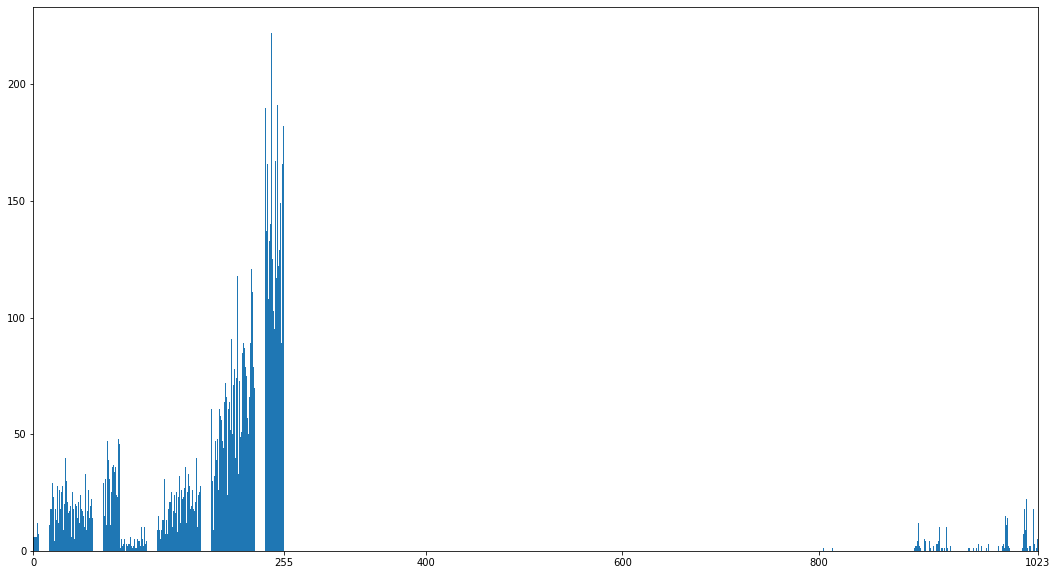

In [94]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values,counts)
ax.set(xlim=(0, 1023), xticks=np.array([0,255,400,600,800,1023]))
plt.show()

In [95]:
# Percentage of correct instances among all generations
counts[values < 256].sum()/generation.shape[1]

0.972

In [96]:
counts[values < 256].size

255

In [97]:
statistics = np.array([values, counts])
for i in range(values.size-1):
    diff = values[i+1] - values[i]
    for j in range(1,diff):
        statistics = np.append(statistics, np.array([[values[i]+j],[0]]),axis = 1)
statistics = np.unique(statistics,axis = 1)
statistics[1,0:256]

array([  6,   6,   6,   6,  12,   7,   5,   8,  22,  11,   5,   9,   4,
         7,  13,  12,   9,  11,  18,  18,  29,  23,   4,  18,  13,  28,
        12,  26,  18,  25,  28,   9,  20,  40,  30,  21,  16,  17,  19,
         6,  25,  18,   5,  20,  19,  14,  21,  12,  24,  18,  17,  15,
        10,  33,   9,  17,  26,  14,  19,  22,  14,  28,  39,  17,  16,
        18,  13,  21,  18,   6,  30,  26,  29,  15,  31,  11,  47,  39,
        31,  11,  25,  36,  37,  34,  36,  24,  23,  48,  46,   1,   5,
         2,   3,   5,   0,   3,   2,   3,   3,   6,   2,   1,   2,   5,
         1,   1,   5,   4,   4,   2,  10,   5,   2,  10,   3,   4,   3,
         4,   4,  12,   6,   7,  12,   7,  12,   7,  12,   9,  15,   9,
         5,   9,  13,  13,  31,   7,  13,   7,  18,  21,  21,  25,  10,
        17,  24,  16,  25,   8,  23,  32,  12,  26,  22,  23,  27,  36,
        12,  25,  33,  28,  18,  19,  26,  18,  17,  21,  40,  10,  24,
        25,  28,  22,  29,  18,  23,  21,  39,  24,  24,  28,  6

In [73]:
Theta

{'Theta_10': array([[ 8.71492027e-03,  9.12434144e-03,  6.02576278e-03,
          4.56707485e-03,  1.40426963e-01, -2.64134319e-02,
         -1.41354080e-02,  2.28364279e-02,  9.34058319e+00],
        [-3.59750468e+00,  7.63219786e-01,  8.10174458e-01,
          1.12514441e-01,  5.05244048e+00,  7.12797267e-02,
         -2.02223557e-01, -1.74391774e-01,  1.48554736e+00],
        [ 3.73917546e-01, -4.30142096e-01,  4.21451488e-02,
         -3.59766109e-01, -3.27345167e+00,  1.30574930e-01,
          2.41698034e-01, -5.06731981e-01,  5.12685560e+00],
        [-3.92591520e+00,  3.32678431e-01,  9.31633969e-01,
         -5.58039338e-01, -3.22484072e+00, -4.44504000e-01,
          2.31454644e-01,  6.12653580e-01,  9.06336087e-01],
        [ 2.56821233e-01,  1.04978145e-01,  5.74783385e-01,
          3.04381683e+00, -8.11428674e-02, -1.13423488e+00,
          5.64197413e-02,  7.59015355e-01,  1.81758608e+00],
        [ 4.85569393e-01,  2.63767722e+00, -2.28252093e-01,
         -6.37142212e-0

### Helmholtz Machine({-1,1}, No bias)

In [206]:
# parameters
n_dz = np.array([10,8,5,3])
init_type = "zero"
Phi, Theta = parameter_initialization_nobias(init_type,n_dz)

In [222]:
n_q = n_dz[1:].sum()
n_p = n_dz.sum()
lr = 0.05
epoch = 300
n_data = well_formed_set.shape[1]

for e in range(epoch):
    error_P_all = 0
    error_Q_all = 0
    for i in range(n_data):
        d0 = well_formed_set[:,i:i+1]
        Q, Alpha_Q = wake_forward_nobias(d0,Phi)
        Theta, info_gain_sleep, error_P = sleep_update_delta_nobias(Theta,Alpha_Q,lr)
        error_P_all += error_P/n_p

        P, Alpha_P = sleep_forward_nobias(Theta)
        Phi, info_gain_wake,error_Q = wake_update_delta_nobias(Phi,Alpha_P,lr)
        error_Q_all += error_Q/n_q

    error_P_all = error_P_all/n_data
    error_Q_all = error_Q_all/n_data
    print(error_P_all,error_Q_all)

0.21144180894898457 0.10851161797378958
0.21132218444951734 0.11041370360960563
0.20963734927898703 0.10508960687117773
0.20856072818619567 0.1093300148223108
0.20664167159803032 0.10361713764264813
0.20549348340252216 0.1040275821708045
0.20454381159117738 0.10088668441397694
0.20301456959811318 0.10111009914665102
0.2057424674733209 0.10499410642121869
0.20829631805675475 0.0992223926358681
0.21175743834841926 0.10986235749122338
0.20597512970673817 0.10246561574911481
0.21062967646260233 0.10723418483124735
0.2064784579142833 0.10371673551099105
0.2088966437906742 0.11557368297022494
0.2055922432720056 0.10605810485977038
0.2094548804890874 0.10883617525145055
0.2106084088470429 0.10045104638073768
0.19950855691556468 0.09204157784967124
0.19903568999728843 0.09744932705645219
0.19998074742742417 0.09531109726650068
0.20522118613456766 0.10252656717032972
0.21103229824324435 0.10313281105960694
0.20816947030655594 0.10450733581686715
0.204332590919339 0.10110490224182393
0.200298520

0.24547984192430858 0.14750785431393817
0.24321753268638144 0.14762216016268476
0.23827044330216365 0.14833077671257971
0.24266973008906262 0.14798305590109395
0.23863733981729648 0.14059427466118946
0.2354465791118978 0.13351694232326441
0.23477840685041332 0.13220651349190254
0.2321246991513295 0.1275829735990318
0.23386504624866564 0.13573166579737736
0.2330392827642621 0.1339235984314507
0.228114456391656 0.12689569382962648
0.23167132273762653 0.1276749452608936
0.23027968989058253 0.13003043664496486
0.23054294057172983 0.13071580833944946
0.2317638417607181 0.1313039199374044
0.2294066534639206 0.1267765355827092
0.23411498623989943 0.13405602146254336
0.23492040041151505 0.13647693752045947
0.22973447244123976 0.12372331194653056
0.22842678937101465 0.12575980205006224
0.23106625239919462 0.121067961627299
0.2292695650130827 0.11629029196904883
0.22840783217151467 0.12190065553299811
0.22619203164494145 0.11700679890544542
0.22843372803007989 0.12341597215498575
0.2238961119557

In [223]:
n_sample = 10000
generation = np.zeros((n_dz[0],n_sample))
for i in range(n_sample):
    generation[:,i:i+1] = generate_nobias(Theta)

In [224]:
distribution = np.zeros((generation.shape[1], ),dtype = int)
for i in range(generation.shape[1]):
    for j in range(reordered_set.shape[1]):
        if np.array_equal(generation[:,i], reordered_set[:,j]):
            distribution[i] = j
            break

In [225]:
values, counts = np.unique(distribution, return_counts=True)
counts.size

619

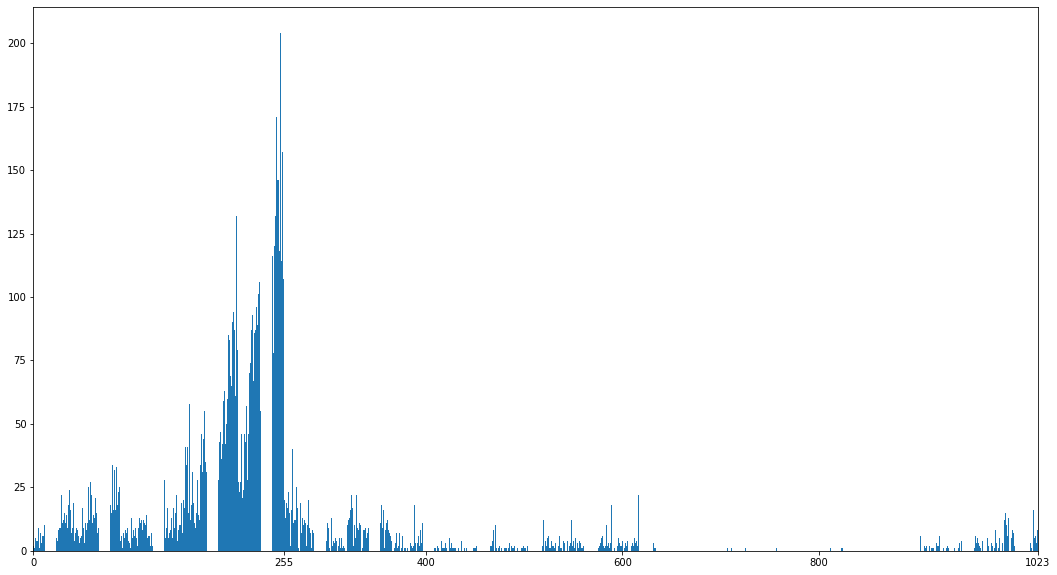

In [226]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values,counts)
ax.set(xlim=(0, 1023), xticks=np.array([0,255,400,600,800,1023]))
plt.show()

In [227]:
# Percentage of correct instances among all generations
counts[values < 256].sum()/generation.shape[1]

0.8143

In [228]:
counts[values < 256].size

256

In [229]:
statistics = np.array([values, counts])
for i in range(values.size-1):
    diff = values[i+1] - values[i]
    for j in range(1,diff):
        statistics = np.append(statistics, np.array([[values[i]+j],[0]]),axis = 1)
statistics = np.unique(statistics,axis = 1)
statistics[:,0:256]

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

### Helmholtz Machine({-1,1}, With bias)

In [230]:
# parameters
n_dz = np.array([10,8,5,3])
init_type = "zero"
Phi, Theta = parameter_initialization(init_type,n_dz)

In [239]:
n_q = n_dz[1:].sum()
n_p = n_dz.sum()
lr = 0.05
epoch = 300
n_data = well_formed_set.shape[1]

for e in range(epoch):
    error_P_all = 0
    error_Q_all = 0
    for i in range(n_data):
        d0 = well_formed_set[:,i:i+1]
        Q, Alpha_Q = wake_forward(d0,Phi)
        Theta, info_gain_sleep, error_P = sleep_update_delta(Theta,Alpha_Q,lr)
        error_P_all += error_P/n_p

        P, Alpha_P = sleep_forward(Theta)
        Phi, info_gain_wake,error_Q = wake_update_delta(Phi,Alpha_P,lr)
        error_Q_all += error_Q/n_q

    error_P_all = error_P_all/n_data
    error_Q_all = error_Q_all/n_data
    print(error_P_all,error_Q_all)

0.25099032671736404 0.17689707891277448
0.2499040624152378 0.17292468640030267
0.255835949025975 0.17802833340270194
0.25648814557706084 0.18091978680818713
0.255026505460202 0.1852384158511488
0.2533620477777227 0.18865158156615017
0.2587343287207544 0.18116280162373524
0.255313903559481 0.1813033905189412
0.2539962373143932 0.17218119153967712
0.24703645614497147 0.17363856159813465
0.24524641429384603 0.17501286669150187
0.2457181289304028 0.16528536020331916
0.2541811745631462 0.17691160895455904
0.24942357084480055 0.17456789113173524
0.24712348761815636 0.17836732418659793
0.2495884787214872 0.17106514536880793
0.24231569343807668 0.1728583136079073
0.24012683072244123 0.17077932111074523
0.2457051436525877 0.17147674005864122
0.23917072922242813 0.17288779329773424
0.24808802710273825 0.17466717406228816
0.2567044577872202 0.18111961593805065
0.25074206983192965 0.18349442553655199
0.24714197596225174 0.16838081099354033
0.24361190601190594 0.16907528863649868
0.2455885421999716

0.20519022111385823 0.11663903770801559
0.20348374281348008 0.1105575004929603
0.20616161260543703 0.11873257911248301
0.20955583779320835 0.1201110807057696
0.20604578105873428 0.11472834305720628
0.20438941767390217 0.1170844155553509
0.207179404417221 0.11167431088470849
0.20558913354819144 0.11663693734184997
0.2017672673191107 0.1073925209426348
0.1944399216312345 0.09855335569552601
0.18826439999311204 0.08851178518421643
0.19121444967707638 0.10054267153800123
0.19223068085059425 0.09517592746015882
0.19199366649481658 0.09928155112624087
0.19208128887906992 0.10094185645912511
0.2005356890975852 0.10560642722252217
0.2042874863526665 0.11112583611579854
0.20579546621951733 0.10797465025442068
0.19975464715564828 0.10754070459440962
0.2006443121581505 0.1096227157465536
0.20071205200463774 0.11390717012517196
0.19708564246728047 0.10909293499274857
0.20169691872738582 0.10824583605155466
0.2020354939750461 0.10940875023188587
0.20019332080253022 0.09939271915560613
0.20079841017

In [240]:
n_sample = 10000
generation = np.zeros((n_dz[0],n_sample))
for i in range(n_sample):
    generation[:,i:i+1] = generate(Theta)

In [241]:
distribution = np.zeros((generation.shape[1], ),dtype = int)
for i in range(generation.shape[1]):
    for j in range(reordered_set.shape[1]):
        if np.array_equal(generation[:,i], reordered_set[:,j]):
            distribution[i] = j
            break

In [242]:
values, counts = np.unique(distribution, return_counts=True)
counts.size

276

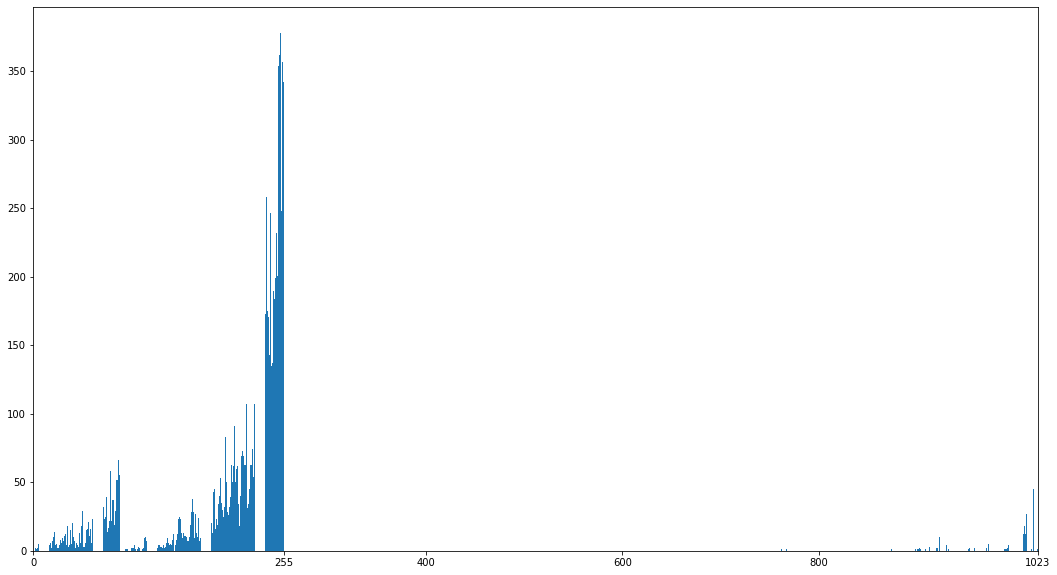

In [243]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.bar(values,counts)
ax.set(xlim=(0, 1023), xticks=np.array([0,255,400,600,800,1023]))
plt.show()

In [244]:
# Percentage of correct instances among all generations
counts[values < 256].sum()/generation.shape[1]

0.9817

In [245]:
counts[values < 256].size

239

In [246]:
statistics = np.array([values, counts])
for i in range(values.size-1):
    diff = values[i+1] - values[i]
    for j in range(1,diff):
        statistics = np.append(statistics, np.array([[values[i]+j],[0]]),axis = 1)
statistics = np.unique(statistics,axis = 1)
statistics[:,0:256]

array([[  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
         67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
         80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
         93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
        119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
        132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
        145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
        158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
        171, 172, 173, 174, 175, 176, 177, 178, 179

In [247]:
Theta

{'Theta_10': array([[-8.36540413e-01, -3.06410059e-02,  3.33452507e-01,
          1.86871027e-01,  1.47692185e-01,  2.98797954e-01,
         -1.08444891e-01,  4.25839228e-01,  8.40150359e+00],
        [-1.43060245e-01,  2.51773504e-01,  8.52681208e-02,
          1.67024130e-01,  2.61627890e-01,  7.43944446e+00,
          1.03944058e-01,  4.00275901e-01,  3.59300167e-01],
        [-5.08203449e-01, -5.17815952e-01, -1.02730378e+00,
         -7.17975308e-02, -8.73390849e-02, -2.47069606e+00,
         -5.00927901e-01, -6.25650531e-01,  6.14668125e+00],
        [-3.86091530e-01, -6.08207898e-01,  3.36814234e+00,
         -5.63881592e-01,  5.57727338e-01, -3.37088739e-01,
          9.29598615e-02,  9.81238007e-01, -2.46873801e+00],
        [ 1.12020512e-02,  2.77705710e+00,  6.26229663e-01,
          1.62100903e-01,  6.34233795e-01, -1.11120596e-01,
          1.48634333e-01, -1.53470477e+00,  4.17997041e+00],
        [-7.06556236e-02, -8.49730182e-01,  6.69893414e-01,
          2.99775682e+0

### Helmholtz Machine({-1,1}, Bias on data only)